In [1]:
#Import relevant libraries
import astropy
import numpy as np
import ccdproc
import os
import glob
import matplotlib.pyplot as plt
from astropy.nddata import CCDData

In [2]:
#Here we will read in the master science B frame and produces background images and a deblended segmentation image of the data provided with all the reductions made

B = astropy.nddata.CCDData.read('C:/Users/steve/OneDrive - University of Birmingham/LH Observatory Laboratory/Glob Cluter Final Code/GlobClusters/MasterScienceB.fits', unit='adu')
#An array of this image has been made
B = np.array(B)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


[[ 99.29965096 117.40860406 118.16163382 ... 202.02897294 195.41588105
   79.6195164 ]
 [ 88.26979771 114.88908224 121.92239395 ... 196.11939645 202.47144922
   78.85739949]
 [ 81.0854117  119.04891925 110.77980342 ... 190.59899581 203.64461893
   79.80941851]
 ...
 [  0.         117.33461056 124.61238126 ... 113.35572437 101.80559285
    0.        ]
 [  0.         117.30052992 120.39544667 ... 125.19744605 130.73839518
    0.        ]
 [  0.           0.           0.         ...   0.           0.
    0.        ]]
(4096, 4096)
193.1067957072249
84.59056365118003


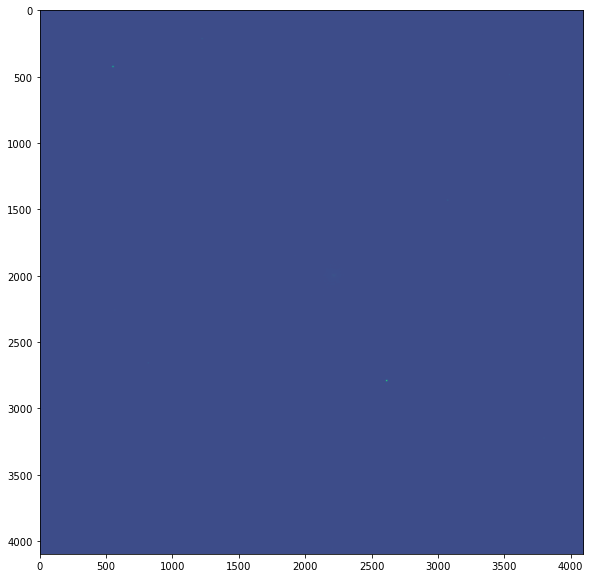

In [3]:
## Show all the B Range science 
#Here we print the standard deviation and mean of our master science B frame and show the image of B 
print(B)
print(B.shape)
plt.figure(1,(10,10))
plt.imshow(B)

mean_B = np.mean(B)
std_B = np.std(B)
print(mean_B)
print(std_B)

192.2201797890617
6.328260030000077


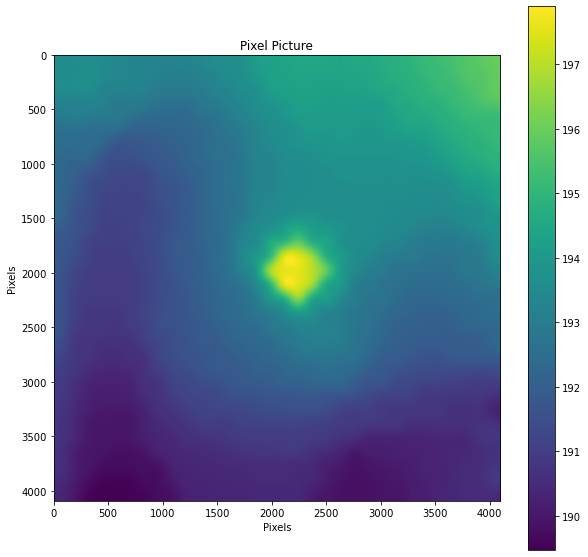

In [4]:
#Here we plot the background of the entire frame detected by B band by using the median 

from astropy.stats import SigmaClip
from photutils.background import Background2D, MedianBackground
sigma_clip = SigmaClip(sigma=3.)
bkg_estimator = MedianBackground()
bkg = Background2D(B, (128, 128), filter_size=(5,5), sigma_clip=sigma_clip, bkg_estimator=bkg_estimator)

print(bkg.background_median)  
print(bkg.background_rms_median)  

bkg_median = bkg.background_median
bkg_rms = bkg.background_rms
bkg_rms_median = bkg.background_rms_median

plt.figure(1,(10,10))
plt.title('Pixel Picture')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.imshow(bkg.background)

cbar = plt.colorbar()

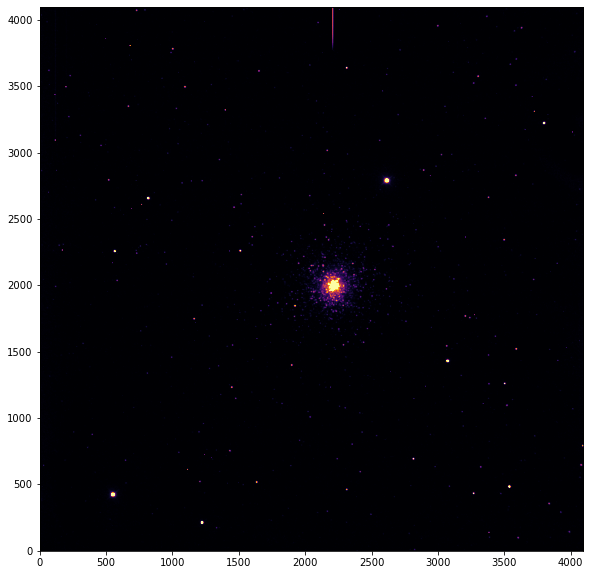

In [5]:
#We now subtract this background from our B image to produce an image highlighting the position of M15

plt.figure(1,(10,10))
plt.imshow(B-bkg.background, vmin=0, vmax=200, cmap='inferno', origin='lower')

Text(0.5, 1.0, 'Segmentation Image')

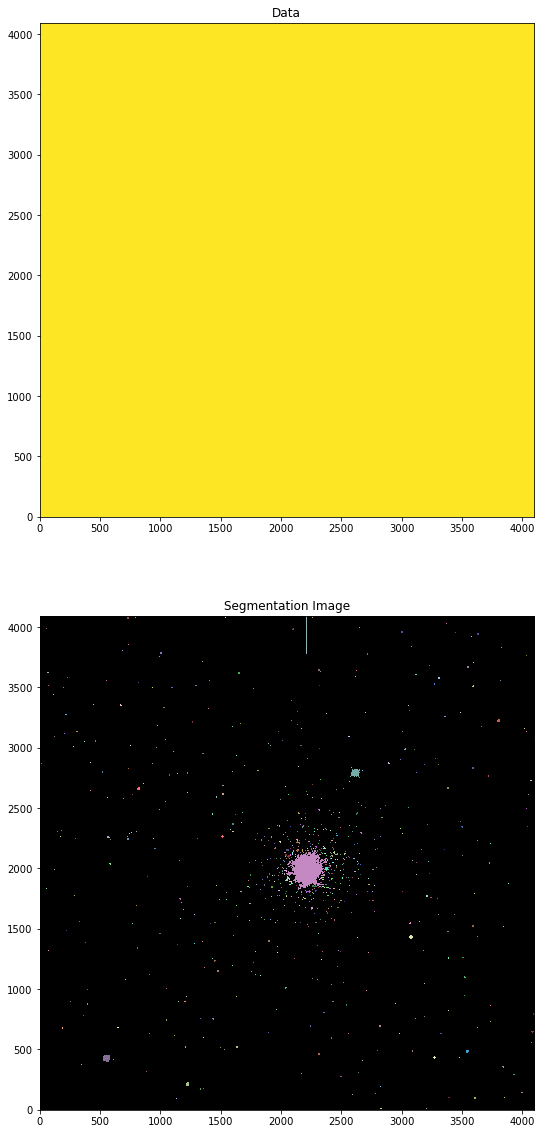

In [6]:
#We now produce our segmentation image which is then subtracted from our master science b to produce the segmentation iamge

from photutils.utils import calc_total_error
from photutils.segmentation import detect_threshold
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils.segmentation import detect_sources
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

threshold = detect_threshold(B, nsigma=3.)

threshold = bkg.background + (2.0 * bkg_rms) 

sigma = 2.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
segm = detect_sources(B, threshold, npixels=3, kernel=kernel)

norm = ImageNormalize(stretch=SqrtStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20))
ax1.imshow(B, vmin=10, vmax=20, origin='lower')
ax1.set_title('Data')
cmap = segm.make_cmap(seed=123)
ax2.imshow(segm, origin='lower', cmap=cmap, interpolation='nearest')
ax2.set_title('Segmentation Image')

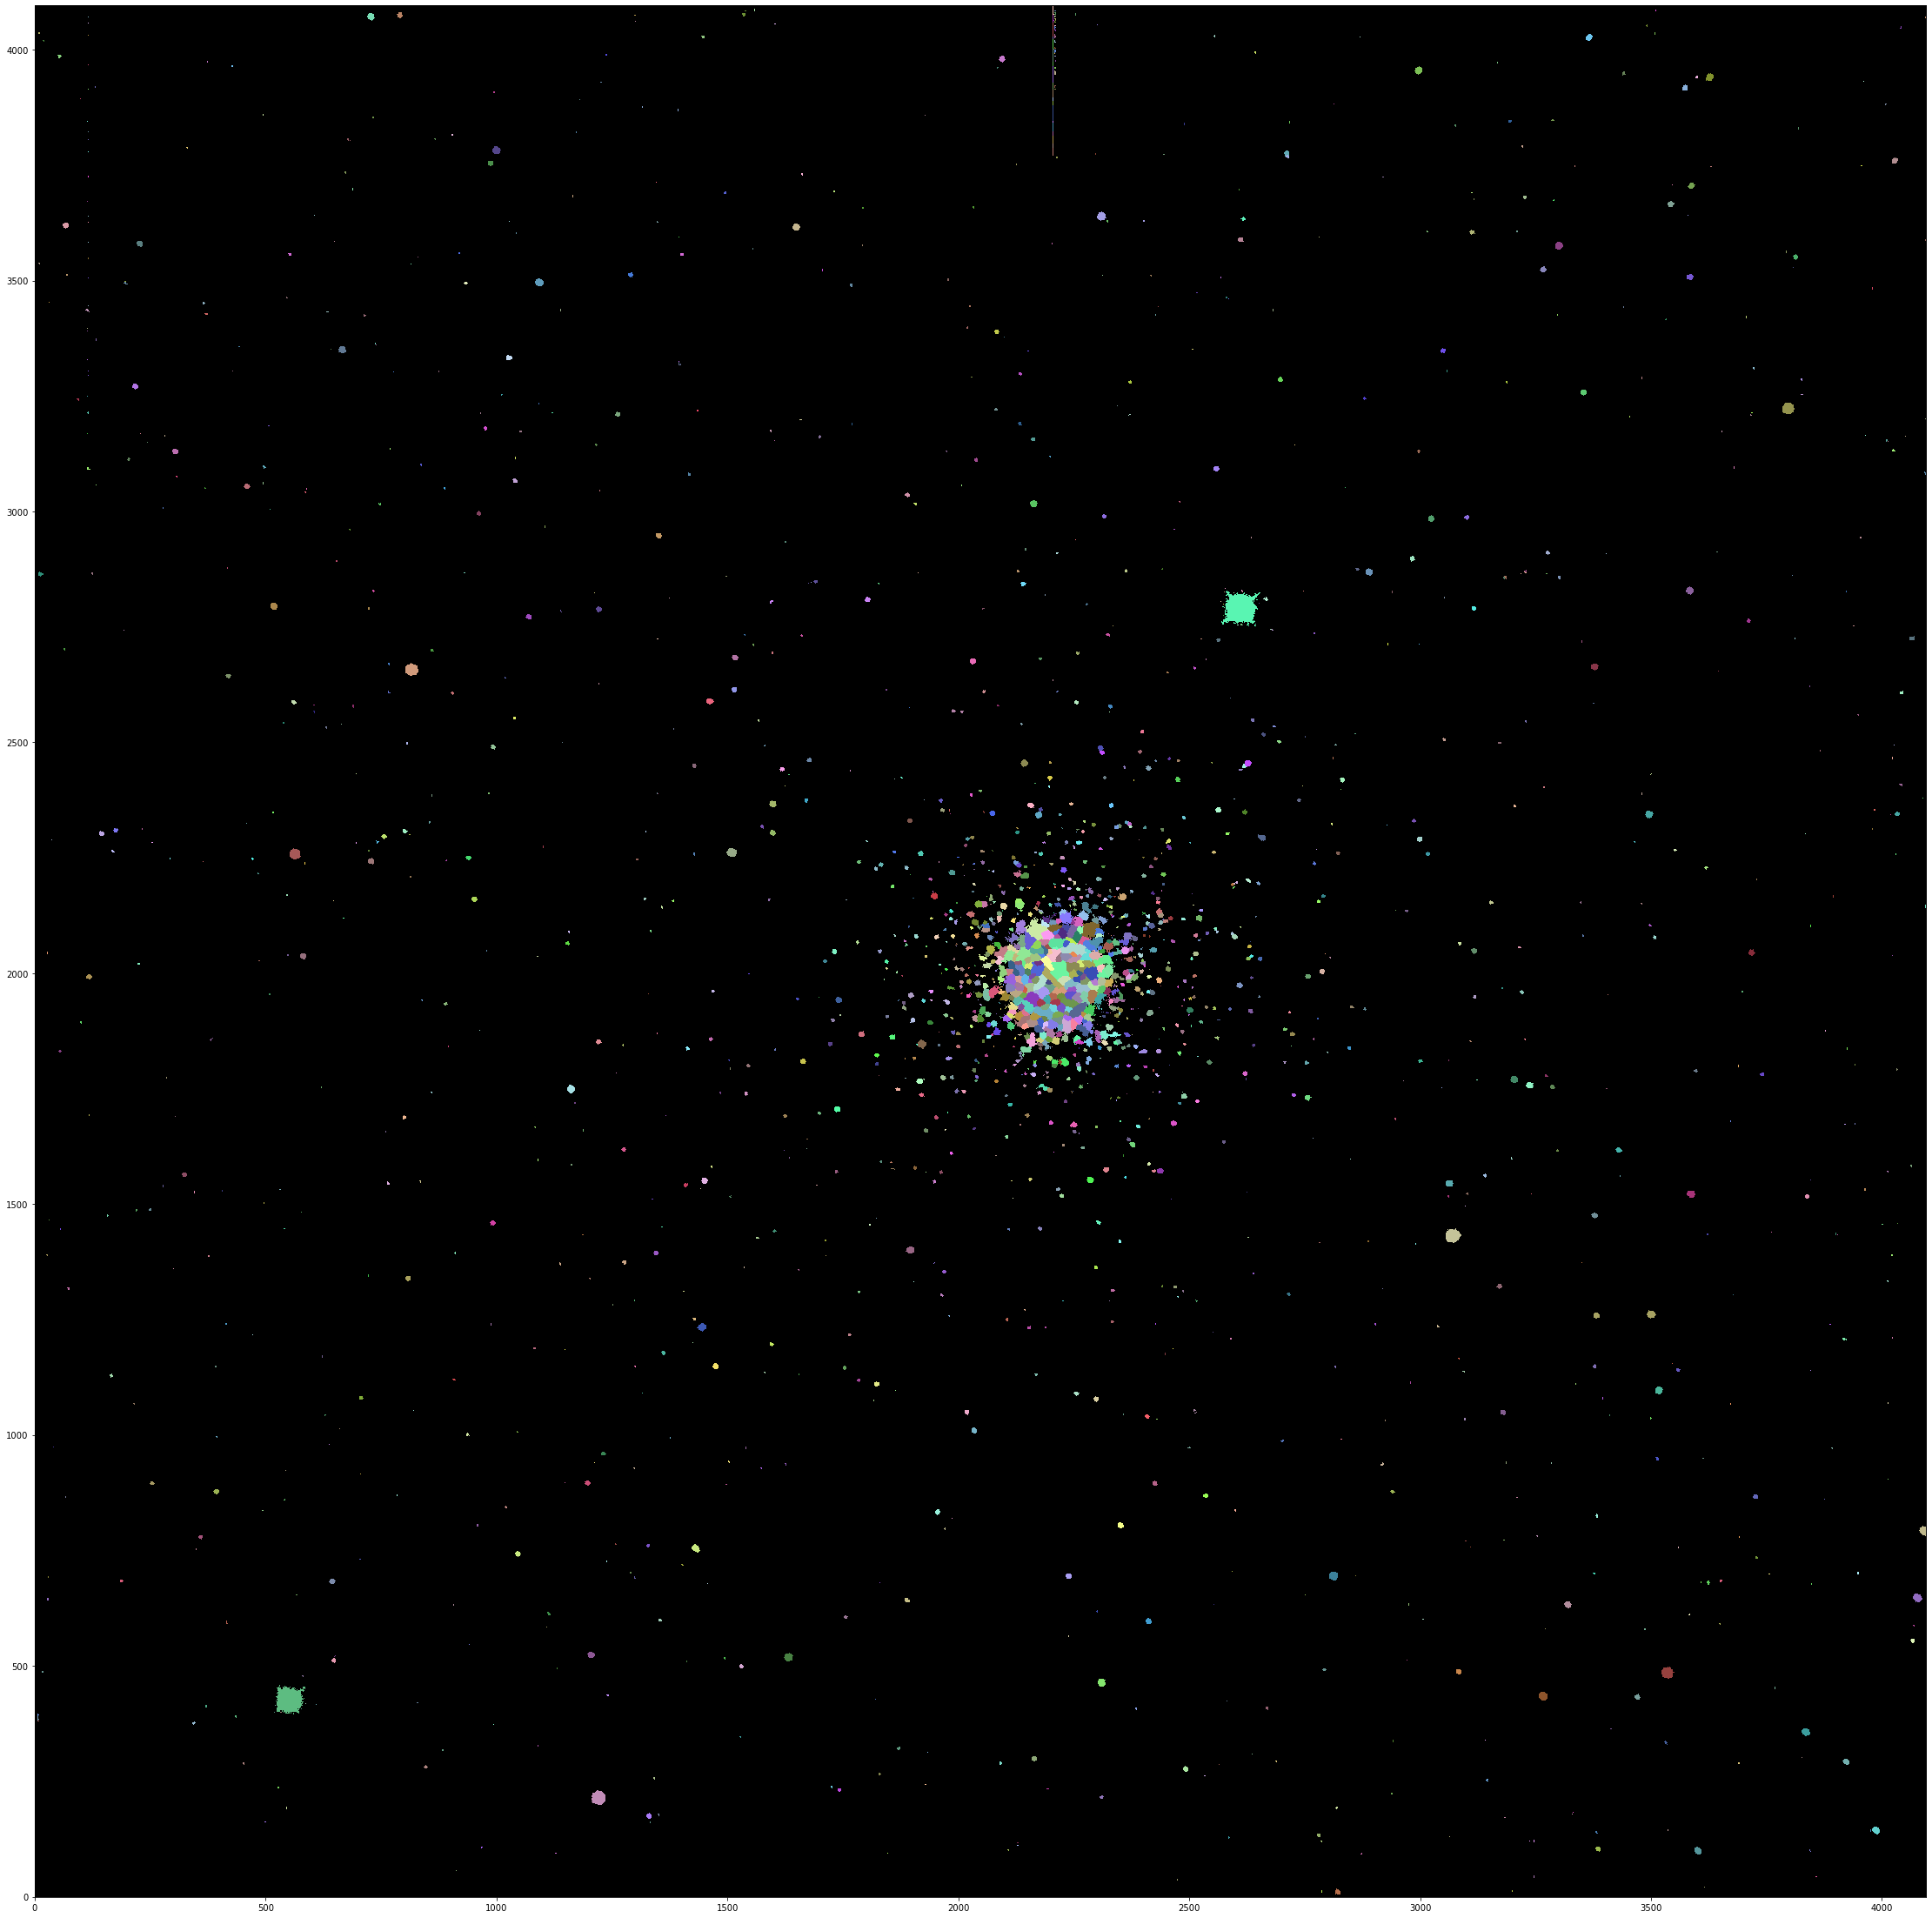

In [8]:
#Here we deblend our image and see multiple indiviudal colour spots corresponding to a different source

from photutils.segmentation import deblend_sources
segm_deblend = deblend_sources(B, segm, npixels=3, kernel=kernel,
                               nlevels=32, contrast=0.001)
plt.figure(1,(40,40))
plt.imshow(segm_deblend, origin='lower', cmap=cmap, interpolation='nearest')

In [9]:
#We now produce our source properties table including any errors on the source sums for future use
from photutils.segmentation import source_properties
error = calc_total_error(B, bkg_error = bkg_rms, effective_gain = 2.2)
table_B = source_properties(B - bkg.background, segm_deblend, error)

        Use `~photutils.segmentation.SourceCatalog` instead. [warnings]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]


In [10]:
tblB = table_B.to_table()
tblB.write('table_B', format = 'ascii', overwrite = True)